In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import gc
import os
import pickle as pkl
import random
import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from tqdm import tqdm

sys.path.append("../util")
from feature_engineering import lag_feature, log_feature, plot_loghist, count_in_session, first_in_session
from utils import reduce_df

input_path = Path('/content/drive/MyDrive/Data_Competitions/SIGIR2021/')

In [3]:
pd.set_option('display.max_columns', None)

In [8]:
SessionId = 'SessionId'

# Load

In [10]:
%%time
all_df = pd.read_csv(input_path / 'product_train_and_test_4.csv')
print(all_df.shape)

(9853698, 17)
CPU times: user 33.4 s, sys: 8.86 s, total: 42.2 s
Wall time: 53.8 s


In [11]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,1,0,14273.0,NaN,False,0,1,0,1,0,0,0.0,0.0
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,1,1,34160.0,NaN,False,0,1,0,1,0,1,0.0,0.0
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,1,1,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,0,2,0,2,34160,0,0.0,0.0
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,1,2,24601.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,5,1,0,6,66355,3,0.0,1.0
4,detail,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,1556994909153,844e0ffaba1166cf5340747060e926980d858d8226a0fb...,1,2,46543.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,6,2,0,8,117944,2,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853693,detail,a532a9b9d11dcb3358677f9ff2d41d95f015331acbd632...,1550718210565,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,0,5553722,14933.0,f07a44501e94ddb9296c7dea9df4772382f0715c313810...,False,6,8,0,14,375053,4,0.0,0.0
9853694,detail,3011fe75d8739f217851a68d4c7ab40cce7dd5031f9080...,1550718249795,53c2241664874b9e7e05515c282bc33ae6665641a985f0...,0,5553722,39230.0,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,6,9,0,15,414283,3,0.0,11.0
9853695,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,0,5553722,22536.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,17,10,0,27,722444,2,0.0,0.0
9853696,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,0,5553722,55768.0,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,17,11,0,28,778212,1,0.0,0.0


In [12]:
all_df.dtypes

product_action                object
product_sku_hash              object
server_timestamp_epoch_ms      int64
hashed_url                    object
is_test                        int64
SessionId                      int64
last_event_length            float64
last_hashed_url               object
same_url                        bool
cum_pageview                   int64
cum_product                    int64
cum_search                     int64
cum_event                      int64
lapse                          int64
cum_product_r                  int64
num_following_search         float64
num_following_pageview       float64
dtype: object

# meta

In [13]:
meta_df = pd.read_csv(input_path / 'meta_df.csv')

In [14]:
meta_df

,product_sku_hash,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null
0,26ce7b47f4c46e4087e83e54d2f7ddc7ea57862fed2e2a...,-1,5.491822,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True
1,6383992be772b204a9ab75f86c86f5583d1bdd1222952d...,-1,5.491822,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True
2,a2c3e2430c6ef9770b903ad08fa067a6b2b9db28f06e1b...,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,7.000000,1.068909e+00,8.834255e-01,1.324272e+00,9.746077e-01,1.536175e+00,-1.622171e+00,1.045164e+00,4.340767e-01,False,False,False
3,1028ef615e425c328e7b95010dfb1fb93cf63749a1bc80...,115a6a7017ee55752b8487c77dfde92b0d501d10a2e69c...,8.000000,1.524474e+00,1.386727e-01,1.344033e+00,-1.199957e-01,8.586212e-01,1.486986e+00,6.908986e-02,-3.181978e-01,False,False,False
4,9870c682d0d52d635501249da0eeaa118fad430b695ea1...,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,2.000000,-1.185310e+00,3.467957e-02,2.697006e-02,-2.319981e+00,-5.359175e-01,5.296150e-01,6.839195e-01,-1.613961e-01,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66381,c7cc673ca3baa5fa222fffdc16379892b3a62583a48143...,-1,5.491822,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True
66382,6641c7d2053ce48ce1e81a9653dffe56dbb79ab0704fbd...,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,3.000000,-7.288378e-01,4.072705e-01,-3.287253e-01,-1.356297e+00,6.004590e-01,2.854491e-01,-2.528333e-01,-1.045365e+00,False,False,False
66383,526a6a51717d5bb40ef2b0c47394d08c54385375633bab...,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,5.000000,-8.255487e-01,-2.347586e+00,-6.461021e-01,-1.805299e+00,-7.418570e-01,4.190546e-01,1.497953e+00,-1.480755e+00,False,False,False
66384,21ca4ab0e2fbd3b401fbeadeb4439dcab9998fb52159ec...,-1,5.491822,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True


In [15]:
for c in ['description_vector', 'description_vector_cleaned', 'image_vector', 'img_vector_cleaned']:
    if c in meta_df.columns:
        del meta_df[c]

In [16]:
all_df = pd.merge(all_df, meta_df, how='left', on='product_sku_hash')

In [17]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,1,0,14273.0,NaN,False,0,1,0,1,0,0,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,8.0,1.593151,1.384917,1.339295,0.021085,1.578851e+00,-1.527748e+00,5.877906e-01,5.028798e-01,False,False,False
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,1,1,34160.0,NaN,False,0,1,0,1,0,1,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,5.0,1.299976,-0.839638,1.121370,0.075403,-7.550825e-01,4.714482e-01,4.280780e-01,-6.071607e-01,False,False,False
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,1,1,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,0,2,0,2,34160,0,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,5.0,1.342221,-1.081300,0.668451,0.225876,-6.666954e-01,1.029353e+00,3.315532e-01,3.212282e-02,False,False,False
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,1,2,24601.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,5,1,0,6,66355,3,0.0,1.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,7.0,-0.771306,-1.067945,-0.412014,-0.688119,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,False,False,True
4,detail,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,1556994909153,844e0ffaba1166cf5340747060e926980d858d8226a0fb...,1,2,46543.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,6,2,0,8,117944,2,0.0,2.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,6.0,-0.643188,-0.747952,-0.130714,-0.070806,-1.008310e+00,5.170295e-01,7.257771e-01,-9.837168e-01,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853693,detail,a532a9b9d11dcb3358677f9ff2d41d95f015331acbd632...,1550718210565,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,0,5553722,14933.0,f07a44501e94ddb9296c7dea9df4772382f0715c313810...,False,6,8,0,14,375053,4,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,9.0,-0.697719,1.121754,-1.167023,-0.058681,-1.100049e+00,8.343042e-02,3.807244e-01,2.238112e-01,False,False,False
9853694,detail,3011fe75d8739f217851a68d4c7ab40cce7dd5031f9080...,1550718249795,53c2241664874b9e7e05515c282bc33ae6665641a985f0...,0,5553722,39230.0,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,6,9,0,15,414283,3,0.0,11.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,9.0,-0.697719,1.121754,-1.167023,-0.058681,-4.157480e-01,3.575162e-01,3.599519e-01,2.715619e-01,False,False,False
9853695,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,0,5553722,22536.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,17,10,0,27,722444,2,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,9.0,1.170328,0.606709,-1.893135,-0.004364,-8.232788e-01,-2.874530e-01,1.192764e-01,4.351507e-01,False,False,False
9853696,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,0,5553722,55768.0,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,17,11,0,28,778212,1,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,9.0,1.228727,0.348225,-1.744241,-0.104023,-7.404750e-01,3.469584e-01,8.430295e-02,5.609313e-01,False,False,False


In [18]:
gc.collect()

50

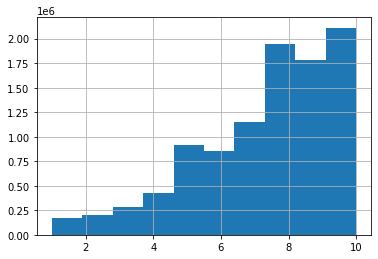

In [19]:
all_df['price_bucket'].hist()

In [20]:
all_df['price_bucket'].isnull().sum()

0

In [21]:
all_df['price_bucket'].mean(), all_df['price_bucket'].std()

(7.4911250970936045, 2.2381627537745974)

In [22]:
all_df['price_bucket'] = (all_df['price_bucket'] - all_df['price_bucket'].mean()) / all_df['price_bucket'].std()

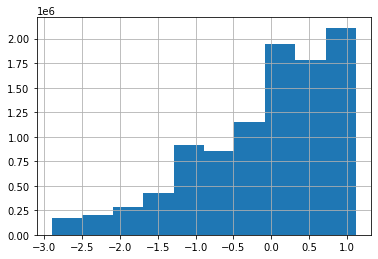

In [23]:
all_df['price_bucket'].hist()

In [24]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,1,0,14273.0,NaN,False,0,1,0,1,0,0,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.227363,1.593151,1.384917,1.339295,0.021085,1.578851e+00,-1.527748e+00,5.877906e-01,5.028798e-01,False,False,False
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,1,1,34160.0,NaN,False,0,1,0,1,0,1,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.299976,-0.839638,1.121370,0.075403,-7.550825e-01,4.714482e-01,4.280780e-01,-6.071607e-01,False,False,False
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,1,1,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,0,2,0,2,34160,0,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.342221,-1.081300,0.668451,0.225876,-6.666954e-01,1.029353e+00,3.315532e-01,3.212282e-02,False,False,False
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,1,2,24601.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,5,1,0,6,66355,3,0.0,1.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.219432,-0.771306,-1.067945,-0.412014,-0.688119,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,False,False,True
4,detail,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,1556994909153,844e0ffaba1166cf5340747060e926980d858d8226a0fb...,1,2,46543.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,6,2,0,8,117944,2,0.0,2.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.666227,-0.643188,-0.747952,-0.130714,-0.070806,-1.008310e+00,5.170295e-01,7.257771e-01,-9.837168e-01,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853693,detail,a532a9b9d11dcb3358677f9ff2d41d95f015331acbd632...,1550718210565,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,0,5553722,14933.0,f07a44501e94ddb9296c7dea9df4772382f0715c313810...,False,6,8,0,14,375053,4,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.674158,-0.697719,1.121754,-1.167023,-0.058681,-1.100049e+00,8.343042e-02,3.807244e-01,2.238112e-01,False,False,False
9853694,detail,3011fe75d8739f217851a68d4c7ab40cce7dd5031f9080...,1550718249795,53c2241664874b9e7e05515c282bc33ae6665641a985f0...,0,5553722,39230.0,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,6,9,0,15,414283,3,0.0,11.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.674158,-0.697719,1.121754,-1.167023,-0.058681,-4.157480e-01,3.575162e-01,3.599519e-01,2.715619e-01,False,False,False
9853695,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,0,5553722,22536.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,17,10,0,27,722444,2,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.674158,1.170328,0.606709,-1.893135,-0.004364,-8.232788e-01,-2.874530e-01,1.192764e-01,4.351507e-01,False,False,False
9853696,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,0,5553722,55768.0,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,17,11,0,28,778212,1,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.674158,1.228727,0.348225,-1.744241,-0.104023,-7.404750e-01,3.469584e-01,8.430295e-02,5.609313e-01,False,False,False


In [25]:
all_df['category_hash'].value_counts()

115a6a7017ee55752b8487c77dfde92b0d501d10a2e69c420d5d535205b27f81/984ecbf26bfdda5928adb40ac89c37d0b90bf80b08d0afbb565fdf692e22e2d8/cb682b47227164bad62a677f3af90f5a4e71accc5f988e687d006d36130cd6d8    2343652
06fa312761d4b39e2f649781514ac69a4c1505c221fc463426d38a2de1679683/49d80fcbc8128f7ea2bfa33cc9e8405f6b604efbbdd8fd77b06ebe367403b2ab/115a6a7017ee55752b8487c77dfde92b0d501d10a2e69c420d5d535205b27f81    1262242
0665a81d19c89281cc00e7f7d779ded2ed42c933838602c303f2364d8e6b7059/a140250159ef8df5e64afa36973cefbb2b28e7b5fe0e40a3fd590238e49166da/dc20b96c06e7fe6089f102a7a3ea60692159cddb1631733c1e581af2d985e67f     692993
06fa312761d4b39e2f649781514ac69a4c1505c221fc463426d38a2de1679683/0e566c6d47aa4853858d8a965cc8ea5195fd23555364a4ac4f74074c5e6b7b87/7279e67dc98586a6003e64e56312b32c9ea54679af8f5ee61d5e35d24911bd49     564895
0665a81d19c89281cc00e7f7d779ded2ed42c933838602c303f2364d8e6b7059/e1fa679aaabbe4a6401748efae18112513767c003283bc3f69aca78b46913c40/dc20b96c06e7fe6089f102a7a3ea60692159cddb163173

In [26]:
all_df['category_hash'].isnull().sum()

0

### target count

In [27]:
tmp_df = all_df.groupby('product_sku_hash').SessionId.count().reset_index()
tmp_df.columns = ['product_sku_hash', 'product_count']
all_df = all_df.merge(tmp_df, how='left', on='product_sku_hash')

In [28]:
gc.collect()

131

In [31]:
all_df['product_sku_hash'].nunique()

61126

In [30]:
all_df['hashed_url'].nunique()

97932

In [32]:
all_df['product_count'].value_counts().sort_index()
# 17862 products appear once

1          18324
2          13324
3           9912
4           7608
5           6525
           ...  
28446      28446
30352      30352
35635      35635
49102      49102
179785    179785
Name: product_count, Length: 2488, dtype: int64

In [33]:
all_df['product_count'].value_counts().sort_index()[:12]

1     18324
2     13324
3      9912
4      7608
5      6525
6      5742
7      5817
8      4864
9      4896
10     4510
11     4752
12     5184
Name: product_count, dtype: int64

(6627.29655769844, 24292.416563037248)

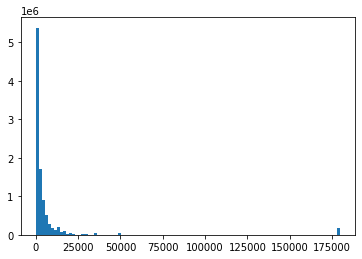

In [34]:
c = 'product_count'
_ = plt.hist(all_df[c], bins=100)
all_df[c].mean(), all_df[c].std()

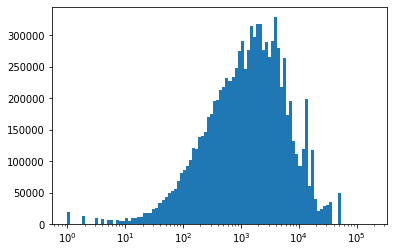

In [35]:
plot_loghist(all_df['product_count'], 100)

In [36]:
del tmp_df
gc.collect()

26520

In [37]:
all_df = count_in_session(all_df, count_col = 'category_hash')

NameError: ignored

In [39]:
all_df = count_in_session(all_df, count_col = 'hashed_url')

In [40]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null,product_count,category_hash_count,hashed_url_count
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,1,0,14273.0,NaN,False,0,1,0,1,0,0,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.227363,1.593151,1.384917,1.339295,0.021085,1.578851e+00,-1.527748e+00,5.877906e-01,5.028798e-01,False,False,False,16921,1262242,15881
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,1,1,34160.0,NaN,False,0,1,0,1,0,1,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.299976,-0.839638,1.121370,0.075403,-7.550825e-01,4.714482e-01,4.280780e-01,-6.071607e-01,False,False,False,1266,329858,1103
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,1,1,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,0,2,0,2,34160,0,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.342221,-1.081300,0.668451,0.225876,-6.666954e-01,1.029353e+00,3.315532e-01,3.212282e-02,False,False,False,342,329858,319
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,1,2,24601.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,5,1,0,6,66355,3,0.0,1.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.219432,-0.771306,-1.067945,-0.412014,-0.688119,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,False,False,True,29,477648,27
4,detail,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,1556994909153,844e0ffaba1166cf5340747060e926980d858d8226a0fb...,1,2,46543.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,6,2,0,8,117944,2,0.0,2.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.666227,-0.643188,-0.747952,-0.130714,-0.070806,-1.008310e+00,5.170295e-01,7.257771e-01,-9.837168e-01,False,False,False,160,477648,141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853693,detail,a532a9b9d11dcb3358677f9ff2d41d95f015331acbd632...,1550718210565,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,0,5553722,14933.0,f07a44501e94ddb9296c7dea9df4772382f0715c313810...,False,6,8,0,14,375053,4,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.674158,-0.697719,1.121754,-1.167023,-0.058681,-1.100049e+00,8.343042e-02,3.807244e-01,2.238112e-01,False,False,False,465,193192,464
9853694,detail,3011fe75d8739f217851a68d4c7ab40cce7dd5031f9080...,1550718249795,53c2241664874b9e7e05515c282bc33ae6665641a985f0...,0,5553722,39230.0,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,6,9,0,15,414283,3,0.0,11.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.674158,-0.697719,1.121754,-1.167023,-0.058681,-4.157480e-01,3.575162e-01,3.599519e-01,2.715619e-01,False,False,False,401,193192,397
9853695,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,0,5553722,22536.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,17,10,0,27,722444,2,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.674158,1.170328,0.606709,-1.893135,-0.004364,-8.232788e-01,-2.874530e-01,1.192764e-01,4.351507e-01,False,False,False,1129,193192,1067
9853696,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,0,5553722,55768.0,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,17,11,0,28,778212,1,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0

### low number targets

In [41]:
LOW_TARGETS_THR = 7

In [44]:
all_df.loc[all_df.product_count <= LOW_TARGETS_THR, 'product_sku_hash'] = -1

In [45]:
all_df[all_df.product_count.isnull()]

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null,product_count,category_hash_count,hashed_url_count


In [46]:
all_df['product_sku_hash'].nunique()

27842

In [47]:
LOW_URLS_THR = 7
c = 'hashed_url'
all_df.loc[all_df[c + '_count'] <= LOW_URLS_THR, c] = -1

In [48]:
all_df[all_df.hashed_url_count.isnull()]

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null,product_count,category_hash_count,hashed_url_count


In [50]:
all_df['hashed_url'].nunique()

28683

In [51]:
CATEGORY_FEATURES = ['product_sku_hash', 'category_hash', 'product_action', 'hashed_url']
mappings = []
for c in CATEGORY_FEATURES:
    all_df[c+'_id'], mp = all_df[c].factorize()
    mappings.append(mp)

created product_sku_hash_id
created category_hash_id
created product_action_id
created hashed_url_id


In [52]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null,product_count,category_hash_count,hashed_url_count,product_sku_hash_id,category_hash_id,product_action_id,hashed_url_id
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,1,0,14273.0,NaN,False,0,1,0,1,0,0,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.227363,1.593151,1.384917,1.339295,0.021085,1.578851e+00,-1.527748e+00,5.877906e-01,5.028798e-01,False,False,False,16921,1262242,15881,0,0,0,0
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,1,1,34160.0,NaN,False,0,1,0,1,0,1,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.299976,-0.839638,1.121370,0.075403,-7.550825e-01,4.714482e-01,4.280780e-01,-6.071607e-01,False,False,False,1266,329858,1103,1,1,0,1
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,1,1,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,0,2,0,2,34160,0,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.342221,-1.081300,0.668451,0.225876,-6.666954e-01,1.029353e+00,3.315532e-01,3.212282e-02,False,False,False,342,329858,319,2,1,0,2
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,1,2,24601.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,5,1,0,6,66355,3,0.0,1.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.219432,-0.771306,-1.067945,-0.412014,-0.688119,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,False,False,True,29,477648,27,3,2,0,3
4,detail,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,1556994909153,844e0ffaba1166cf5340747060e926980d858d8226a0fb...,1,2,46543.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,6,2,0,8,117944,2,0.0,2.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.666227,-0.643188,-0.747952,-0.130714,-0.070806,-1.008310e+00,5.170295e-01,7.257771e-01,-9.837168e-01,False,False,False,160,477648,141,4,2,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853693,detail,a532a9b9d11dcb3358677f9ff2d41d95f015331acbd632...,1550718210565,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,0,5553722,14933.0,f07a44501e94ddb9296c7dea9df4772382f0715c313810...,False,6,8,0,14,375053,4,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.674158,-0.697719,1.121754,-1.167023,-0.058681,-1.100049e+00,8.343042e-02,3.807244e-01,2.238112e-01,False,False,False,465,193192,464,3451,28,0,3448
9853694,detail,3011fe75d8739f217851a68d4c7ab40cce7dd5031f9080...,1550718249795,53c2241664874b9e7e05515c282bc33ae6665641a985f0...,0,5553722,39230.0,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,6,9,0,15,414283,3,0.0,11.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.674158,-0.697719,1.121754,-1.167023,-0.058681,-4.157480e-01,3.575162e-01,3.599519e-01,2.715619e-01,False,False,False,401,193192,397,16348,28,0,16165
9853695,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,0,5553722,22536.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,17,10,0,27,722444,2,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.674158,1.170328,0.606709,-1.893135,-0.004364,-8.232788e-01,-2.874530e-01,1.192764e-01,4.351507e-01,False,False,False,1129,193192,1067,6078,28,0,6054
9853696,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b5

In [53]:
all_df[all_df['product_sku_hash'] == -1]

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null,product_count,category_hash_count,hashed_url_count,product_sku_hash_id,category_hash_id,product_action_id,hashed_url_id
6,detail,-1,1556995004703,-1,1,2,38926.0,22c1ce2d23943c5180f95685abe9b0ce6d2046a6586c18...,False,9,4,0,13,213494,0,0.0,1.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.219432,-7.311139e-01,-1.400212e+00,-6.617940e-01,-1.016753e+00,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,False,False,True,7,477648,7,6,2,0,6
64,detail,-1,1557080264911,-1,1,43,32215.0,0c517f9c51d989cc4a9d6f647e2f263d46c31663d8fc00...,False,2,1,0,3,56627,1,0.0,1.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,-0.219432,-8.642015e-01,7.097542e-01,-4.673542e-01,7.787010e-01,-3.832618e-01,-9.968439e-01,-3.422842e-01,-1.011133e+00,False,False,False,5,18145,4,6,15,0,6
212,detail,-1,1556643402166,-1,1,139,5302.0,b5f96fabead6e3cd84150cc04fd80903b36aca4cfd0a53...,False,69,3,0,72,2764995,7,0.0,1.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.666227,-6.705405e-01,-1.151881e+00,1.101436e-01,2.442196e+00,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,False,False,True,1,25050,1,6,6,0,6
214,detail,-1,1556643449972,-1,1,139,4318.0,b4cee2dc1ca9058dc66f2202792a59625ce02b490cf58d...,False,73,5,0,78,2812801,5,0.0,3.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.666227,-5.044783e-01,-1.138312e+00,-4.304705e-01,2.529671e+00,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,False,False,True,6,25050,6,6,6,0,6
215,detail,-1,1556643475245,-1,1,139,5278.0,b8f569b7912ea0dc63f0a2c3ae75354a9e309e83f7e888...,False,76,6,0,82,2838074,4,0.0,3.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,0.227363,-3.755625e-01,-1.350132e+00,2.272030e-01,1.749887e+00,-6.091474e-01,5.255405e-01,7.383419e-01,3.461876e+00,False,False,False,3,25050,3,6,6,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9852297,remove,-1,1554145319299,-1,0,5552923,5038.0,38f5bd3c9a1cc5b39e6b965f1aa6c565737f58e19a560a...,False,43,27,0,70,2119086,1,0.0,2.0,-1,-0.893279,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True,5,335551,1,6,43,2,6
9853362,remove,-1,1553560482934,-1,0,5553541,10019.0,38f5bd3c9a1cc5b39e6b965f1aa6c565737f58e19a560a...,False,17,21,1,39,680488,13,0.0,1.0,-1,-0.893279,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True,5,335551,1,6,43,2,6
9853366,remove,-1,1553560523415,-1,0,5553541,2140.0,38f5bd3c9a1cc5b39e6b965f1aa6c565737f58e19a560a...,False,21,25,1,47,720969,9,0.0,1.0,-1,-0.893279,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True,4,335551,1,6,43,2,6
9853425,remove,-1,1547904567147,0f25eb73288ebdaf59208dced356b98e9c85078e0636c3...,0,5553578,262165.0,38f5bd3c9a1cc5b39e6b965f1aa6c565737f58e19a560a...,False,18,7,1,26,727715,1,0.0,3.0,-1,-0.893279,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True,4,335551,15569,6,43,2,1309


In [54]:
LOW_TARGETS = np.where(mappings[0] == -1)[0][0]
LOW_TARGETS

6

In [55]:
mappings

[Index(['bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4adefbe55239b3817fdf5',
        'e1d919d93793d553de030e9f6c7524a7db96f5b459688152262a23d280a5b250',
        '9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d22b33ff9d581dd0d5e9',
        '379afa673527cf5b494a5b3c6decdbcd2e4b2247e1548527616d57c3bf2dfe74',
        'ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed067e8f4fcbece068ae4',
        '3823c0ae0866a92c93c18ba4af63169128edb0cd679affd5418e25084b121c61',
                                                                        -1,
        'fa2f22b63f20f974310deec8da2c76b6fb0057683a0ceaf037b861fea82069e0',
        '409308a78b45af2d988eef583eb35a80cb5c89f294f77111a41a5af22e7e9592',
        '3c96575eab701b1a4d99d1a8718f115eb27fd51c7e3f77c85607e3a62d6da573',
        ...
        '6410e74d501f3cc209a2ed9204a780116906e49a6f0eb8ac66ff58556dfb1eda',
        'df58ba01f6ea298d26631ff52a718f4e4c6cf3704ea40afa2b52d0f50d23cf78',
        'ea24954ad8183a479871bf03220dfcd795f4afa653361f6599b2625ae125f33a',


In [56]:
with open(input_path / 'mappings_stage2.pkl', mode='wb') as f:
    pkl.dump(mappings, f)

In [ ]:
#NUM_TARGETS = all_df.product_sku_hash_id.max() + 1
#NUM_TARGETS

26690

In [57]:
all_df['product_count'] = log_feature(all_df, 'product_count')

4.610130882096816e-11 1.7276949444651621


(4.610130882096816e-11, 1.7276949444651621)

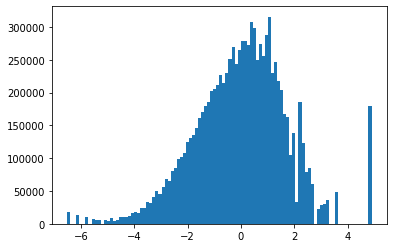

In [58]:
c = 'product_count'
_ = plt.hist(all_df[c], bins=100)
all_df[c].mean(), all_df[c].std()

In [61]:
all_df['category_hash_count'].isnull().sum()

0

3.782468258818947e-10 1.5281078120130858


(3.782468258818947e-10, 1.5281078120130858)

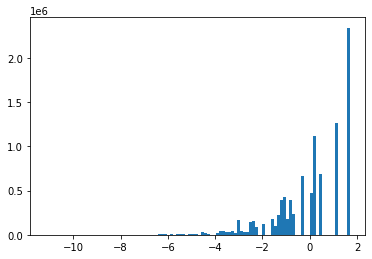

In [59]:
c = 'category_hash_count'

all_df[c] = log_feature(all_df, c)
_ = plt.hist(all_df[c], bins=100)
all_df[c].mean(), all_df[c].std()

In [62]:
c = 'hashed_url_count'
all_df[c].isnull().sum()

0

-2.1631401973445508e-11 2.0997232539388646


(-2.1631401973445508e-11, 2.0997232539388646)

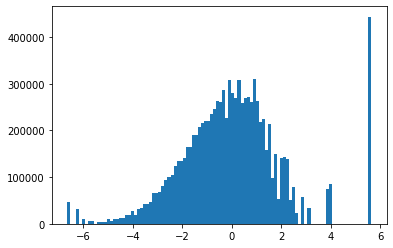

In [63]:
c = 'hashed_url_count'

all_df[c] = log_feature(all_df, c)
_ = plt.hist(all_df[c], bins=100)
all_df[c].mean(), all_df[c].std()

In [64]:
all_df['sorting'] = range(all_df.shape[0])

In [65]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null,product_count,category_hash_count,hashed_url_count,product_sku_hash_id,category_hash_id,product_action_id,hashed_url_id,sorting
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,1,0,14273.0,NaN,False,0,1,0,1,0,0,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.227363,1.593151,1.384917,1.339295,0.021085,1.578851e+00,-1.527748e+00,5.877906e-01,5.028798e-01,False,False,False,2.529928,1.075753,2.316171,0,0,0,0,0
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,1,1,34160.0,NaN,False,0,1,0,1,0,1,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.299976,-0.839638,1.121370,0.075403,-7.550825e-01,4.714482e-01,4.280780e-01,-6.071607e-01,False,False,False,-0.062035,-0.266227,-0.350076,1,1,0,1,1
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,1,1,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,0,2,0,2,34160,0,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.342221,-1.081300,0.668451,0.225876,-6.666954e-01,1.029353e+00,3.315532e-01,3.212282e-02,False,False,False,-1.368712,-0.266227,-1.588450,2,1,0,2,2
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,1,2,24601.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,5,1,0,6,66355,3,0.0,1.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.219432,-0.771306,-1.067945,-0.412014,-0.688119,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,False,False,True,-3.805245,0.103984,-4.024567,3,2,0,3,3
4,detail,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,1556994909153,844e0ffaba1166cf5340747060e926980d858d8226a0fb...,1,2,46543.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,6,2,0,8,117944,2,0.0,2.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.666227,-0.643188,-0.747952,-0.130714,-0.070806,-1.008310e+00,5.170295e-01,7.257771e-01,-9.837168e-01,False,False,False,-2.125038,0.103984,-2.400944,4,2,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853693,detail,a532a9b9d11dcb3358677f9ff2d41d95f015331acbd632...,1550718210565,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,0,5553722,14933.0,f07a44501e94ddb9296c7dea9df4772382f0715c313810...,False,6,8,0,14,375053,4,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.674158,-0.697719,1.121754,-1.167023,-0.058681,-1.100049e+00,8.343042e-02,3.807244e-01,2.238112e-01,False,False,False,-1.062257,-0.801202,-1.214734,3451,28,0,3448,9853693
9853694,detail,3011fe75d8739f217851a68d4c7ab40cce7dd5031f9080...,1550718249795,53c2241664874b9e7e05515c282bc33ae6665641a985f0...,0,5553722,39230.0,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,6,9,0,15,414283,3,0.0,11.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.674158,-0.697719,1.121754,-1.167023,-0.058681,-4.157480e-01,3.575162e-01,3.599519e-01,2.715619e-01,False,False,False,-1.209990,-0.801202,-1.370319,16348,28,0,16165,9853694
9853695,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,0,5553722,22536.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,17,10,0,27,722444,2,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.674158,1.170328,0.606709,-1.893135,-0.004364,-8.232788e-01,-2.874530e-01,1.192764e-01,4.351507e-01,False,False,False,-0.176469

In [66]:
gc.collect()

18572

In [67]:
all_df.dtypes

product_action                object
product_sku_hash              object
server_timestamp_epoch_ms      int64
hashed_url                    object
is_test                        int64
SessionId                      int64
last_event_length            float64
last_hashed_url               object
same_url                        bool
cum_pageview                   int64
cum_product                    int64
cum_search                     int64
cum_event                      int64
lapse                          int64
cum_product_r                  int64
num_following_search         float64
num_following_pageview       float64
category_hash                 object
price_bucket                 float64
description_0                float64
description_1                float64
description_2                float64
description_3                float64
img_0                        float64
img_1                        float64
img_2                        float64
img_3                        float64
p

In [68]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          26073       12584       11927           1        1561       18918
Swap:             0           0           0


In [69]:
%%time
all_df.to_csv(input_path / 'product_train_test_5.csv', index=False)

CPU times: user 5min 46s, sys: 12.4 s, total: 5min 58s
Wall time: 6min 28s


# RELOAD

In [9]:
%%time
all_df = pd.read_csv(input_path / 'product_train_test_5.csv')

CPU times: user 1min 21s, sys: 9.73 s, total: 1min 31s
Wall time: 1min 47s


In [10]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          26073        9635         226           1       16211       21242
Swap:             0           0           0


### lag feartures

In [11]:
NUM_TARGETS = all_df.product_sku_hash_id.max() + 1
NUM_TARGETS

27842

In [12]:
LAGS = 19
lag_targets = []

for i in range(1, LAGS+1):
    all_df[f'product_hash_lag{i}'] = lag_feature(all_df, SessionId, 'product_sku_hash_id', i, NUM_TARGETS).astype('int32')
    lag_targets.append(f'product_hash_lag{i}')

In [13]:
lag_targets

['product_hash_lag1',
 'product_hash_lag2',
 'product_hash_lag3',
 'product_hash_lag4',
 'product_hash_lag5',
 'product_hash_lag6',
 'product_hash_lag7',
 'product_hash_lag8',
 'product_hash_lag9',
 'product_hash_lag10',
 'product_hash_lag11',
 'product_hash_lag12',
 'product_hash_lag13',
 'product_hash_lag14',
 'product_hash_lag15',
 'product_hash_lag16',
 'product_hash_lag17',
 'product_hash_lag18',
 'product_hash_lag19']

In [14]:
all_df[lag_targets]

,product_hash_lag1,product_hash_lag2,product_hash_lag3,product_hash_lag4,product_hash_lag5,product_hash_lag6,product_hash_lag7,product_hash_lag8,product_hash_lag9,product_hash_lag10,product_hash_lag11,product_hash_lag12,product_hash_lag13,product_hash_lag14,product_hash_lag15,product_hash_lag16,product_hash_lag17,product_hash_lag18,product_hash_lag19
0,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842
1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842
2,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842
3,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842
4,3,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853693,18134,22551,18437,10007,17268,14864,3451,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842
9853694,3451,18134,22551,18437,10007,17268,14864,3451,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842
9853695,16348,3451,18134,22551,18437,10007,17268,14864,3451,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842
9853696,6078,16348,3451,18134,22551,18437,10007,17268,14864,3451,27842,27842,27842,27842,27842,27842,27842,27842,27842


In [15]:
for c in lag_targets:
    print((all_df[c] == NUM_TARGETS).sum())

1938344
3750076
4976118
5849291
6509103
7016325
7418694
7742565
8008886
8229996
8415737
8573217
8708270
8824478
8925539
9013727
9091318
9159653
9220350


In [16]:
NUM_CATEGORIES = all_df.category_hash_id.max() + 1
NUM_CATEGORIES

174

In [17]:
LAGS_CATEGORY = 19
lag_categories = []

for i in range(1, LAGS_CATEGORY+1):
    all_df[f'category_lag{i}'] = lag_feature(all_df, SessionId, 'category_hash_id', i, NUM_CATEGORIES).astype('int32')
    lag_categories.append(f'category_lag{i}')

In [18]:
NUM_URLS = all_df.hashed_url_id.max() + 1
NUM_URLS

28683

In [19]:
LAGS_URL = 19
lag_urls = []

for i in range(1, LAGS_URL+1):
    all_df[f'url_lag{i}'] = lag_feature(all_df, SessionId, 'hashed_url_id', i, NUM_URLS).astype('int32')
    lag_urls.append(f'url_lag{i}')

In [20]:
LAGS_VECTOR = 1
lag_vectors = []

for v in ['description', 'img']:
    for k in range(4):
        for i in range(1, LAGS_VECTOR+1):
            all_df[f'{v}_{k}_lag{i}'] = lag_feature(all_df, SessionId, f'{v}_{k}', i, 0).astype('float32')
            lag_vectors.append(f'{v}_{k}_lag{i}')

In [21]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null,product_count,category_hash_count,hashed_url_count,product_sku_hash_id,category_hash_id,product_action_id,hashed_url_id,sorting,product_hash_lag1,product_hash_lag2,product_hash_lag3,product_hash_lag4,product_hash_lag5,product_hash_lag6,product_hash_lag7,product_hash_lag8,product_hash_lag9,product_hash_lag10,product_hash_lag11,product_hash_lag12,...,product_hash_lag16,product_hash_lag17,product_hash_lag18,product_hash_lag19,category_lag1,category_lag2,category_lag3,category_lag4,category_lag5,category_lag6,category_lag7,category_lag8,category_lag9,category_lag10,category_lag11,category_lag12,category_lag13,category_lag14,category_lag15,category_lag16,category_lag17,category_lag18,category_lag19,url_lag1,url_lag2,url_lag3,url_lag4,url_lag5,url_lag6,url_lag7,url_lag8,url_lag9,url_lag10,url_lag11,url_lag12,url_lag13,url_lag14,url_lag15,url_lag16,url_lag17,url_lag18,url_lag19,description_0_lag1,description_1_lag1,description_2_lag1,description_3_lag1,img_0_lag1,img_1_lag1,img_2_lag1,img_3_lag1
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,1,0,14273.0,NaN,False,0,1,0,1,0,0,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.227363,1.593151,1.384917,1.339295,0.021085,1.578851e+00,-1.527748e+00,5.877906e-01,5.028798e-01,False,False,False,2.529928,1.075753,2.316171,0,0,0,0,0,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,27842,27842,27842,27842,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,1,1,34160.0,NaN,False,0,1,0,1,0,1,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.299976,-0.839638,1.121370,0.075403,-7.550825e-01,4.714482e-01,4.280780e-01,-6.071607e-01,False,False,False,-0.062035,-0.266227,-0.350076,1,1,0,1,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,27842,27842,27842,27842,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,1,1,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,0,2,0,2,34160,0,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.342221,-1.081300,0.668451,0.225876,-6.666954e-01,1.029353e+00,3.315532e-01,3.212282e-02,False,False,False,-1.368712,-0.266227,-1.588450,2,1,0,2,2,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,27842,27842,27842,27842,1,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,1,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,1.299976,-0.839638,1.121370,0.075403,-7.550824e-01,4.714482e-01,4.280780e-01,-6.071606e-01
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,1,2,24601.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,5,1,0,6,66355,3,0.0,1.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.219432,-0.771306,-1.067945,-0.412014,-0.688119,8.89

In [ ]:
del all_df['sorting'], all_df['category_hash'], all_df['product_sku_hash'], all_df['hashed_url'], all_df['last_hashed_url']

In [22]:
%%time
all_df.to_csv(input_path / 'product_train_test_6.csv', index=False)

CPU times: user 10min 9s, sys: 14.9 s, total: 10min 24s
Wall time: 11min 6s


In [9]:
%%time
all_df = pd.read_csv(input_path / 'product_train_test_6.csv')

CPU times: user 2min 45s, sys: 36.2 s, total: 3min 21s
Wall time: 3min 39s


In [10]:
%%time
all_df = reduce_df(all_df)
all_df.dtypes

timestamp
CPU times: user 1min 15s, sys: 5.69 s, total: 1min 21s
Wall time: 1min 21s


### first target and category for each session

In [11]:
%%time
all_df = first_in_session(all_df, 'product_sku_hash_id', 'first_product')

CPU times: user 16.9 s, sys: 2.11 s, total: 19 s
Wall time: 18.9 s


In [12]:
%%time
all_df = first_in_session(all_df, 'category_hash_id', 'first_category')

CPU times: user 18.8 s, sys: 3.75 s, total: 22.5 s
Wall time: 22.3 s


first url should be created before filtering.

In [13]:
%%time
all_df = first_in_session(all_df, 'hashed_url_id', 'first_url')

CPU times: user 19.1 s, sys: 2.38 s, total: 21.5 s
Wall time: 21.3 s


In [14]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null,product_count,category_hash_count,hashed_url_count,product_sku_hash_id,category_hash_id,product_action_id,hashed_url_id,sorting,product_hash_lag1,product_hash_lag2,product_hash_lag3,product_hash_lag4,product_hash_lag5,product_hash_lag6,product_hash_lag7,product_hash_lag8,product_hash_lag9,product_hash_lag10,product_hash_lag11,product_hash_lag12,...,product_hash_lag19,category_lag1,category_lag2,category_lag3,category_lag4,category_lag5,category_lag6,category_lag7,category_lag8,category_lag9,category_lag10,category_lag11,category_lag12,category_lag13,category_lag14,category_lag15,category_lag16,category_lag17,category_lag18,category_lag19,url_lag1,url_lag2,url_lag3,url_lag4,url_lag5,url_lag6,url_lag7,url_lag8,url_lag9,url_lag10,url_lag11,url_lag12,url_lag13,url_lag14,url_lag15,url_lag16,url_lag17,url_lag18,url_lag19,description_0_lag1,description_1_lag1,description_2_lag1,description_3_lag1,img_0_lag1,img_1_lag1,img_2_lag1,img_3_lag1,first_product,first_category,first_url
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,1,0,14273.0,NaN,0,0,1,0,1,0,0,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.227363,1.593151,1.384917,1.339295,0.021085,1.578851e+00,-1.527748e+00,5.877905e-01,5.028797e-01,0,0,0,2.529928,1.075753,2.316170,0,0,0,0,0,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,27842,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,1,1,34160.0,NaN,0,0,1,0,1,0,1,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.299976,-0.839638,1.121370,0.075403,-7.550824e-01,4.714482e-01,4.280780e-01,-6.071606e-01,0,0,0,-0.062035,-0.266227,-0.350076,1,1,0,1,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,27842,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,1,1
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,1,1,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,0,0,2,0,2,34160,0,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.342221,-1.081300,0.668451,0.225876,-6.666954e-01,1.029353e+00,3.315532e-01,3.212282e-02,0,0,0,-1.368712,-0.266227,-1.588450,2,1,0,2,2,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,27842,1,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,1,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,1.299976,-0.839638,1.121370,0.075403,-7.550824e-01,4.714482e-01,4.280780e-01,-6.071606e-01,1,1,1
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,1,2,24601.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,0,5,1,0,6,66355,3,0.0,1.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.219432,-0.771306,-1.067945,-0.412014,-0.688119,8.895090e-18,2.066455e-17,-5.549159e-18,-1.593524e-17,0,0,1,-3.805245,0.103984,-4.024567,3,2,0,3,3,27842,27842

In [15]:
%%time
all_df.to_csv(input_path / 'product_train_test_7.csv', index=False)

CPU times: user 9min 31s, sys: 15.5 s, total: 9min 47s
Wall time: 10min 27s


In [9]:
%%time
all_df = pd.read_csv(input_path / 'product_train_test_7.csv')

CPU times: user 2min 17s, sys: 28.8 s, total: 2min 46s
Wall time: 2min 58s


In [10]:
gc.collect()

44

### time

In [11]:
all_df['time'] = (all_df['server_timestamp_epoch_ms'] / 1000).astype(int)
all_df['time'] = pd.to_datetime(all_df['time'].astype(int), unit='s')

In [12]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null,product_count,category_hash_count,hashed_url_count,product_sku_hash_id,category_hash_id,product_action_id,hashed_url_id,sorting,product_hash_lag1,product_hash_lag2,product_hash_lag3,product_hash_lag4,product_hash_lag5,product_hash_lag6,product_hash_lag7,product_hash_lag8,product_hash_lag9,product_hash_lag10,product_hash_lag11,product_hash_lag12,...,category_lag1,category_lag2,category_lag3,category_lag4,category_lag5,category_lag6,category_lag7,category_lag8,category_lag9,category_lag10,category_lag11,category_lag12,category_lag13,category_lag14,category_lag15,category_lag16,category_lag17,category_lag18,category_lag19,url_lag1,url_lag2,url_lag3,url_lag4,url_lag5,url_lag6,url_lag7,url_lag8,url_lag9,url_lag10,url_lag11,url_lag12,url_lag13,url_lag14,url_lag15,url_lag16,url_lag17,url_lag18,url_lag19,description_0_lag1,description_1_lag1,description_2_lag1,description_3_lag1,img_0_lag1,img_1_lag1,img_2_lag1,img_3_lag1,first_product,first_category,first_url,time
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,1,0,14273.0,NaN,0,0,1,0,1,0,0,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.227363,1.593151,1.384917,1.339295,0.021085,1.578851e+00,-1.527748e+00,5.877906e-01,5.028797e-01,0,0,0,2.529928,1.075753,2.316171,0,0,0,0,0,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,2019-05-07 16:47:35
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,1,1,34160.0,NaN,0,0,1,0,1,0,1,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.299976,-0.839638,1.121370,0.075403,-7.550824e-01,4.714482e-01,4.280780e-01,-6.071606e-01,0,0,0,-0.062035,-0.266227,-0.350076,1,1,0,1,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,1,1,2019-04-26 03:47:12
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,1,1,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,0,0,2,0,2,34160,0,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.342221,-1.081300,0.668451,0.225876,-6.666954e-01,1.029353e+00,3.315532e-01,3.212282e-02,0,0,0,-1.368712,-0.266227,-1.588450,2,1,0,2,2,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,1,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,1,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,1.299976,-0.839638,1.121370,0.075403,-7.550824e-01,4.714482e-01,4.280780e-01,-6.071606e-01,1,1,1,2019-04-26 03:47:46
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,1,2,24601.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,0,5,1,0,6,66355,3,0.0,1.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.219432,-0.771306,-1.067945,-0.412014,-0.688119,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,0,0,1,-3.805245,0.103984,-4.

In [13]:
all_df['dayofweek'] = all_df.time.dt.weekday
all_df['hour'] = all_df.time.dt.hour

In [14]:
all_df['weekend'] = all_df['dayofweek'].isin([5, 6]).astype('int8')

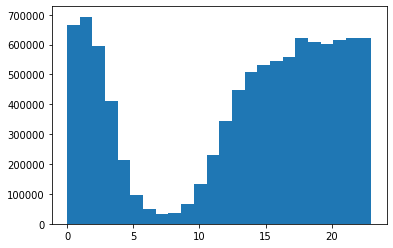

In [15]:
_ = plt.hist(all_df['hour'], 24)

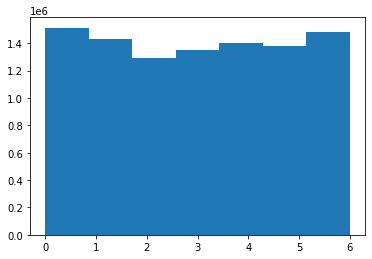

In [16]:
_ = plt.hist(all_df['dayofweek'], 7)

In [17]:
gc.collect()

3998

### event length

(55400.91036584737, 146483.17416679993)

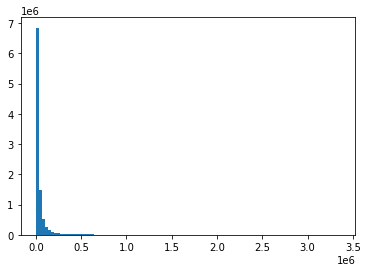

In [18]:
c = 'last_event_length'
_ = plt.hist(all_df[c], bins=100)
all_df[c].mean(), all_df[c].std()

In [19]:
all_df['last_event_length'].isnull().sum()

0

In [20]:
(all_df['last_event_length'] == 0).sum()

24254

In [21]:
all_df['last_event_length'] /= 1000
all_df['last_event_length'] = log_feature(all_df, 'last_event_length')

1.0473422264007552e-13 1.251971814406783


(1.0473422264007552e-13, 1.251971814406783)

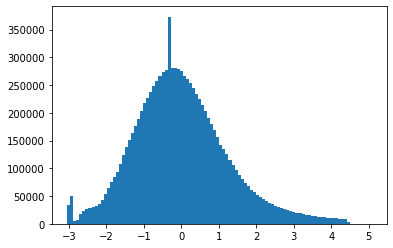

In [22]:
c = 'last_event_length'
_ = plt.hist(all_df[c], bins=100)
all_df[c].mean(), all_df[c].std()

In [23]:
gc.collect()

21546

### lapse

(438775.76994241145, 740054.4238219612)

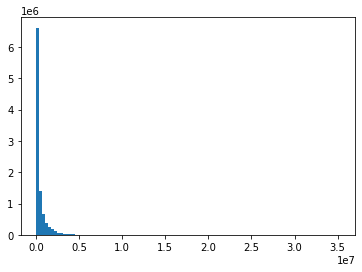

In [24]:
_ = plt.hist(all_df['lapse'], bins=100)
all_df['lapse'].mean(), all_df['lapse'].std()

In [25]:
all_df['lapse'] /= 1000
all_df['lapse'] = log_feature(all_df, 'lapse')

3.090422891868641e-13 2.149917517199611


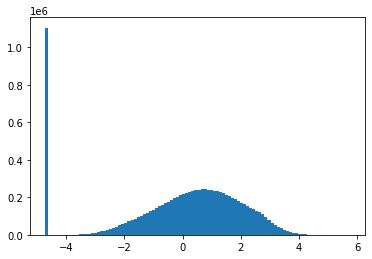

In [26]:
_ = plt.hist(all_df['lapse'], bins=100)

In [27]:
%%time
all_df = reduce_df(all_df)
all_df.dtypes

timestamp
CPU times: user 1min 33s, sys: 8.05 s, total: 1min 41s
Wall time: 1min 41s


In [28]:
%%time
all_df.to_csv(input_path / 'product_train_test_8.csv', index=False)

### event counters

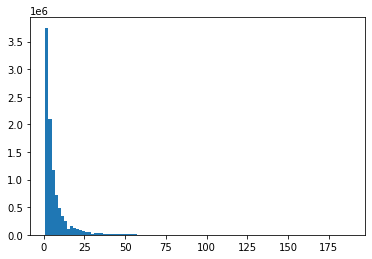

In [29]:
_ = plt.hist(all_df['cum_product'], bins=100)

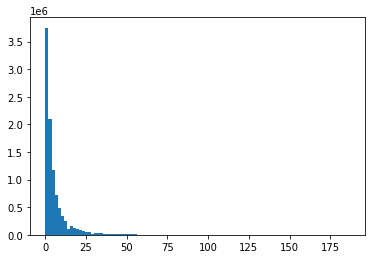

In [30]:
_ = plt.hist(all_df['cum_product_r'], bins=100)

In [31]:
# not to subtract the means so that we can refer zeros later
all_df['cum_product'] = np.log1p(all_df['cum_product'])

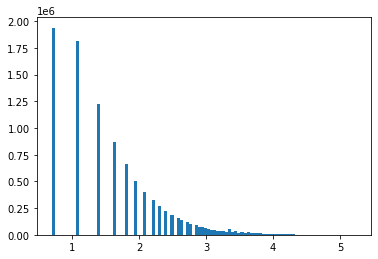

In [32]:
_ = plt.hist(all_df['cum_product'], bins=100)

In [33]:
all_df['cum_product'] = all_df['cum_product'] - all_df['cum_product'].min()

In [34]:
(all_df['cum_product'] == 0).sum()

1938344

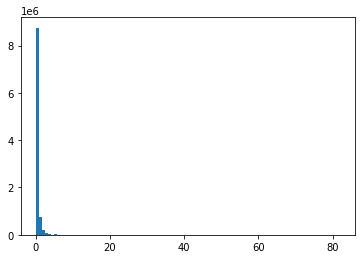

In [35]:
_ = plt.hist(all_df['cum_search'], bins=100)

In [36]:
all_df['cum_search_last'] = lag_feature(all_df, SessionId, 'cum_search', 1, 0).astype('int32')

In [37]:
all_df[all_df['cum_search'] > 0][['cum_search', 'cum_search_last']]

,cum_search,cum_search_last
26,1,0
27,1,1
28,1,1
46,1,0
145,1,0
...,...,...
9853559,2,2
9853560,2,2
9853597,1,0
9853598,1,1


In [38]:
all_df['num_search'] = all_df['cum_search'] - all_df['cum_search_last']

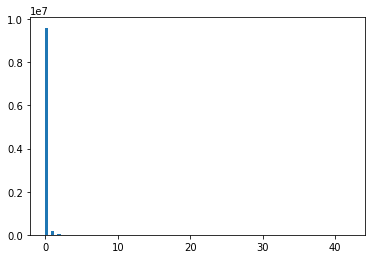

In [39]:
_ = plt.hist(all_df['num_search'], bins=100)

-1.5192704387941246e-12 0.31023683481079867


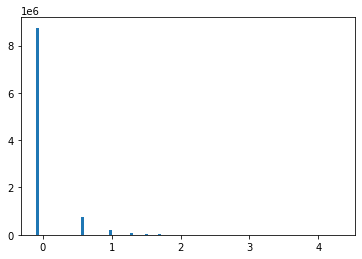

In [40]:
all_df['cum_search'] = log_feature(all_df, 'cum_search')
_ = plt.hist(all_df['cum_search'], bins=100)

-9.426551619838553e-14 0.13273338602607143


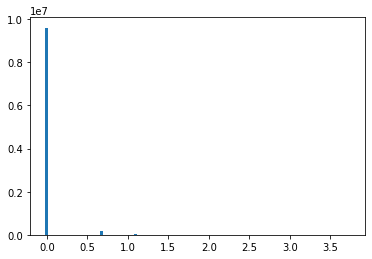

In [41]:
all_df['num_search'] = log_feature(all_df, 'num_search')
_ = plt.hist(all_df['num_search'], bins=100)

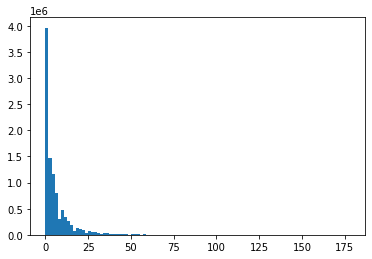

In [42]:
_ = plt.hist(all_df['cum_pageview'], bins=100)

In [43]:
all_df['cum_pageview_last'] = lag_feature(all_df, SessionId, 'cum_pageview', 1, 0).astype('int32')
all_df[all_df['cum_pageview'] > 0][['cum_pageview', 'cum_pageview_last']]

,cum_pageview,cum_pageview_last
3,5,0
4,6,5
5,8,6
6,9,8
7,4,0
...,...,...
9853693,6,6
9853694,6,6
9853695,17,6
9853696,17,17


In [44]:
all_df['num_pageview'] = all_df['cum_pageview'] - all_df['cum_pageview_last']

In [45]:
all_df[:30]

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null,product_count,category_hash_count,hashed_url_count,product_sku_hash_id,category_hash_id,product_action_id,hashed_url_id,sorting,product_hash_lag1,product_hash_lag2,product_hash_lag3,product_hash_lag4,product_hash_lag5,product_hash_lag6,product_hash_lag7,product_hash_lag8,product_hash_lag9,product_hash_lag10,product_hash_lag11,product_hash_lag12,...,category_lag8,category_lag9,category_lag10,category_lag11,category_lag12,category_lag13,category_lag14,category_lag15,category_lag16,category_lag17,category_lag18,category_lag19,url_lag1,url_lag2,url_lag3,url_lag4,url_lag5,url_lag6,url_lag7,url_lag8,url_lag9,url_lag10,url_lag11,url_lag12,url_lag13,url_lag14,url_lag15,url_lag16,url_lag17,url_lag18,url_lag19,description_0_lag1,description_1_lag1,description_2_lag1,description_3_lag1,img_0_lag1,img_1_lag1,img_2_lag1,img_3_lag1,first_product,first_category,first_url,time,dayofweek,hour,weekend,cum_search_last,num_search,cum_pageview_last,num_pageview
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,1,0,-0.318374,NaN,0,0,0.000000,-0.101426,1,-4.723478,0,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.227363,1.593151,1.384917,1.339295,0.021085,1.578851e+00,-1.527748e+00,5.877905e-01,5.028797e-01,0,0,0,2.529928,1.075753,2.316170,0,0,0,0,0,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,174,174,174,174,174,174,174,174,174,174,174,174,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,2019-05-07 16:47:35,1,16,0,0,-0.020465,0,0
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,1,1,0.515448,NaN,0,0,0.000000,-0.101426,1,-4.723478,1,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.299976,-0.839638,1.121370,0.075403,-7.550824e-01,4.714482e-01,4.280780e-01,-6.071606e-01,0,0,0,-0.062035,-0.266227,-0.350076,1,1,0,1,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,174,174,174,174,174,174,174,174,174,174,174,174,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,1,1,2019-04-26 03:47:12,4,3,0,0,-0.020465,0,0
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,1,1,0.515448,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,0,0,0.405465,-0.101426,2,-1.163569,0,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.342221,-1.081300,0.668451,0.225876,-6.666954e-01,1.029353e+00,3.315532e-01,3.212282e-02,0,0,0,-1.368712,-0.266227,-1.588450,2,1,0,2,2,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,174,174,174,174,174,174,174,174,174,174,174,174,1,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,1.299976,-0.839638,1.121370,0.075403,-7.550824e-01,4.714482e-01,4.280780e-01,-6.071606e-01,1,1,1,2019-04-26 03:47:46,4,3,0,0,-0.020465,0,0
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,1,2,0.198171,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,0,5,0.000000,-0.101426,6,-0.513501,3,0.0,1.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.219432,-0.771306,-1.067945,-0.412014,-0.688119,8.895090e-18,2.066455e-17

-6.082063476807461e-12 1.1225375923549166


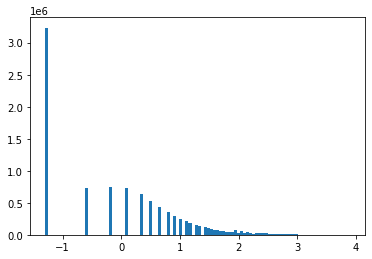

In [46]:
all_df['cum_pageview'] = log_feature(all_df, 'cum_pageview')
_ = plt.hist(all_df['cum_pageview'], bins=100)

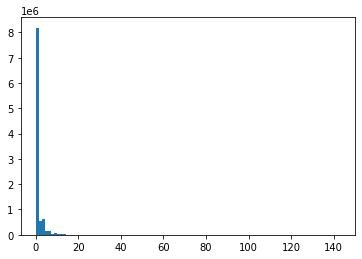

In [47]:
_ = plt.hist(all_df['num_pageview'], bins=100)

-4.087666367023864e-12 0.6130354877731613


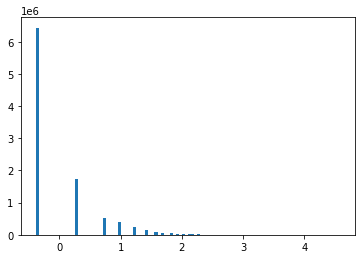

In [48]:
all_df['num_pageview'] = log_feature(all_df, 'num_pageview')
_ = plt.hist(all_df['num_pageview'], bins=100)

In [49]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null,product_count,category_hash_count,hashed_url_count,product_sku_hash_id,category_hash_id,product_action_id,hashed_url_id,sorting,product_hash_lag1,product_hash_lag2,product_hash_lag3,product_hash_lag4,product_hash_lag5,product_hash_lag6,product_hash_lag7,product_hash_lag8,product_hash_lag9,product_hash_lag10,product_hash_lag11,product_hash_lag12,...,category_lag8,category_lag9,category_lag10,category_lag11,category_lag12,category_lag13,category_lag14,category_lag15,category_lag16,category_lag17,category_lag18,category_lag19,url_lag1,url_lag2,url_lag3,url_lag4,url_lag5,url_lag6,url_lag7,url_lag8,url_lag9,url_lag10,url_lag11,url_lag12,url_lag13,url_lag14,url_lag15,url_lag16,url_lag17,url_lag18,url_lag19,description_0_lag1,description_1_lag1,description_2_lag1,description_3_lag1,img_0_lag1,img_1_lag1,img_2_lag1,img_3_lag1,first_product,first_category,first_url,time,dayofweek,hour,weekend,cum_search_last,num_search,cum_pageview_last,num_pageview
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,1,0,-0.318374,NaN,0,-1.294394,0.000000,-0.101426,1,-4.723478,0,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.227363,1.593151,1.384917,1.339295,0.021085,1.578851e+00,-1.527748e+00,5.877905e-01,5.028797e-01,0,0,0,2.529928,1.075753,2.316170,0,0,0,0,0,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,174,174,174,174,174,174,174,174,174,174,174,174,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,2019-05-07 16:47:35,1,16,0,0,-0.020465,0,-0.385034
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,1,1,0.515448,NaN,0,-1.294394,0.000000,-0.101426,1,-4.723478,1,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.299976,-0.839638,1.121370,0.075403,-7.550824e-01,4.714482e-01,4.280780e-01,-6.071606e-01,0,0,0,-0.062035,-0.266227,-0.350076,1,1,0,1,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,174,174,174,174,174,174,174,174,174,174,174,174,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,1,1,2019-04-26 03:47:12,4,3,0,0,-0.020465,0,-0.385034
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,1,1,0.515448,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,0,-1.294394,0.405465,-0.101426,2,-1.163569,0,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.342221,-1.081300,0.668451,0.225876,-6.666954e-01,1.029353e+00,3.315532e-01,3.212282e-02,0,0,0,-1.368712,-0.266227,-1.588450,2,1,0,2,2,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,174,174,174,174,174,174,174,174,174,174,174,174,1,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,1.299976,-0.839638,1.121370,0.075403,-7.550824e-01,4.714482e-01,4.280780e-01,-6.071606e-01,1,1,1,2019-04-26 03:47:46,4,3,0,0,-0.020465,0,-0.385034
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,1,2,0.198171,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,0,0.497366,0.000000,-0.101426,6,-0.513501,3,0.0,1.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-0.219432,-0.771306,

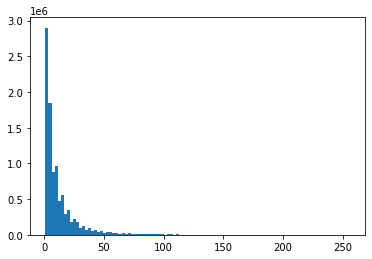

In [50]:
c = 'cum_event'
_ = plt.hist(all_df[c], bins=100)

6.275714770077017e-11 0.9537691878795078


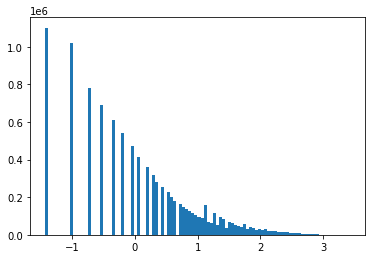

In [51]:
c = 'cum_event'
all_df[c] = log_feature(all_df, c)
_ = plt.hist(all_df[c], bins=100)

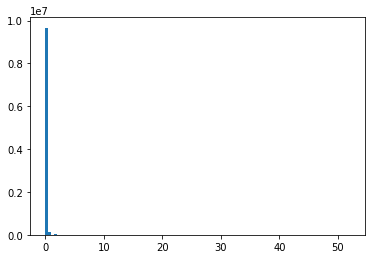

In [52]:
c = 'num_following_search'
_ = plt.hist(all_df[c], bins=100)

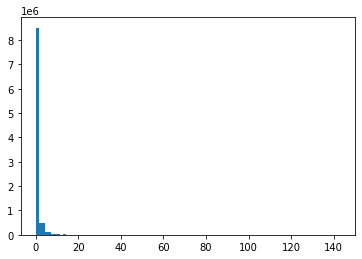

In [53]:
c = 'num_following_pageview'
_ = plt.hist(all_df[c], bins=100)

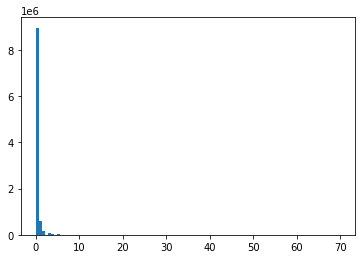

In [54]:
c = 'cum_search_last'
_ = plt.hist(all_df[c], bins=100)

-1.0692343511575651e-12 0.28429377336714273


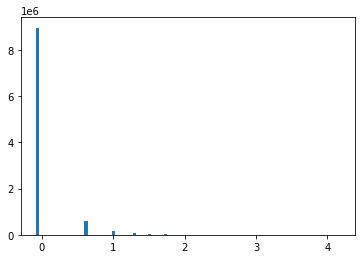

In [55]:
c = 'cum_search_last'
all_df[c] = log_feature(all_df, c)
_ = plt.hist(all_df[c], bins=100)

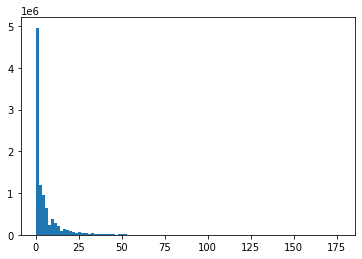

In [56]:
c = 'cum_pageview_last'
_ = plt.hist(all_df[c], bins=100)

-1.6614236862696075e-11 1.1426736018524732


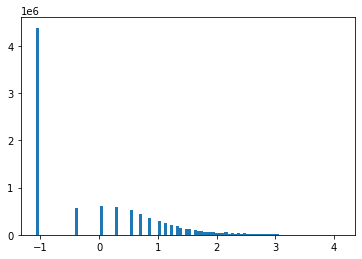

In [57]:
c = 'cum_pageview_last'
all_df[c] = log_feature(all_df, c)
_ = plt.hist(all_df[c], bins=100)

In [58]:
gc.collect()

87

In [59]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          26073       18734         352           1        6985       22872
Swap:             0           0           0


In [60]:
%%time
all_df = reduce_df(all_df)
all_df.dtypes

timestamp
CPU times: user 989 ms, sys: 264 ms, total: 1.25 s
Wall time: 1.25 s


In [61]:
%%time
all_df.to_csv(input_path / 'product_train_test_9.csv', index=False)

CPU times: user 11min 37s, sys: 17.9 s, total: 11min 55s
Wall time: 12min 43s


### targets

In [62]:
all_df = all_df.rename(columns={'product_sku_hash_id': 'product_hash_lag0'})

In [63]:
NUM_TARGETS = all_df['product_hash_lag0'].max() + 1

In [64]:
all_df['next_product'] = lag_feature(all_df, SessionId, 'product_hash_lag0', -1, NUM_TARGETS).astype('int32')

In [82]:
lag_targets += ['product_hash_lag0']

NameError: ignored

In [83]:
lag_targets

NameError: ignored

In [65]:
all_df.columns

Index(['product_action', 'product_sku_hash', 'server_timestamp_epoch_ms',
       'hashed_url', 'is_test', 'SessionId', 'last_event_length',
       'last_hashed_url', 'same_url', 'cum_pageview',
       ...
       'first_url', 'time', 'dayofweek', 'hour', 'weekend', 'cum_search_last',
       'num_search', 'cum_pageview_last', 'num_pageview', 'next_product'],
      dtype='object', length=115)

In [66]:
gc.collect()

202

In [67]:
LOW_TARGETS = 6

In [68]:
((all_df.cum_product_r > 0) & (all_df['next_product'] == LOW_TARGETS)).sum()

62483

In [69]:
((all_df.cum_product_r > 0) & (all_df['next_product'] == NUM_TARGETS)).sum()

1938344

In [70]:
all_df['next_next_product'] = lag_feature(all_df, 'SessionId', 'next_product', -1, LOW_TARGETS).astype('int32')

In [71]:
all_df.loc[all_df['next_product'] == LOW_TARGETS, 'next_product'] = all_df.loc[all_df['next_product'] == LOW_TARGETS, 'next_next_product']

In [75]:
((all_df.cum_product_r > 0) & (all_df['next_product'] == LOW_TARGETS)).sum()

10723

In [76]:
((all_df.cum_product_r > 0) & (all_df['next_product'] == NUM_TARGETS)).sum()

12721

In [77]:
all_df.loc[all_df['next_product'] == NUM_TARGETS, 'next_product'] = LOW_TARGETS

# fold

In [78]:
N_FOLD = 5

all_df['fold'] = 0
group_kfold = GroupKFold(n_splits=N_FOLD)
for fold, (train_idx, test_idx) in enumerate(group_kfold.split(X=all_df, groups=all_df[SessionId])):
    all_df.iloc[test_idx, len(all_df.columns)-1] = fold

all_df['fold'].value_counts()

2    1970740
1    1970740
0    1970740
4    1970739
3    1970739
Name: fold, dtype: int64

In [79]:
all_df.columns

Index(['product_action', 'product_sku_hash', 'server_timestamp_epoch_ms',
       'hashed_url', 'is_test', 'SessionId', 'last_event_length',
       'last_hashed_url', 'same_url', 'cum_pageview',
       ...
       'dayofweek', 'hour', 'weekend', 'cum_search_last', 'num_search',
       'cum_pageview_last', 'num_pageview', 'next_product',
       'next_next_product', 'fold'],
      dtype='object', length=117)

In [ ]:
#all_df = pd.read_csv(input_path / 'browsing_train_test_5.csv', index_col=0)

### unnecessary cols

### cols to remove
product\_action, product\_sku\_hash, hashed\_url, server\_timestamp\_epoch\_ms, session\_id2, 
time, next_event_time, first_time, last_time

### cols not to use
SessionId, sorting,

### cols to use
istest, fold, product\_count, product_sku_hash_id, product_hash_lag{k}, first_product, dayofweek, hour, lapse, event_length, weekend, event_count, event_count_r, add, purchase, remove, next_product

In [81]:
cols_to_remove = ['product_action', 'product_sku_hash', 'server_timestamp_epoch_ms', 'hashed_url', 'last_hashed_url', 'same_url', 'category_hash', 'sorting', 'time', 'next_event_time', 'first_time', 'last_time', 'count_search_last', 'count_pageview_last', 'category_hash']

In [82]:
for c in cols_to_remove:
    if c in all_df.columns:
        del all_df[c]

In [80]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null,product_count,category_hash_count,hashed_url_count,product_hash_lag0,category_hash_id,product_action_id,hashed_url_id,sorting,product_hash_lag1,product_hash_lag2,product_hash_lag3,product_hash_lag4,product_hash_lag5,product_hash_lag6,product_hash_lag7,product_hash_lag8,product_hash_lag9,product_hash_lag10,product_hash_lag11,product_hash_lag12,...,category_lag11,category_lag12,category_lag13,category_lag14,category_lag15,category_lag16,category_lag17,category_lag18,category_lag19,url_lag1,url_lag2,url_lag3,url_lag4,url_lag5,url_lag6,url_lag7,url_lag8,url_lag9,url_lag10,url_lag11,url_lag12,url_lag13,url_lag14,url_lag15,url_lag16,url_lag17,url_lag18,url_lag19,description_0_lag1,description_1_lag1,description_2_lag1,description_3_lag1,img_0_lag1,img_1_lag1,img_2_lag1,img_3_lag1,first_product,first_category,first_url,time,dayofweek,hour,weekend,cum_search_last,num_search,cum_pageview_last,num_pageview,next_product,next_next_product,fold
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,1,0,-0.318374,NaN,0,-1.294394,0.000000,-0.101426,-1.430364,-4.723478,0,0.0,0.0,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,0.227363,1.593151,1.384917,1.339295,0.021085,1.578851e+00,-1.527748e+00,5.877905e-01,5.028797e-01,0,0,0,2.529928,1.075753,2.316170,0,0,0,0,0,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,174,174,174,174,174,174,174,174,174,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,2019-05-07 16:47:35,1,16,0,-0.083016,-0.020465,-1.079889,-0.385034,6,6,2
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,1,1,0.515448,NaN,0,-1.294394,0.000000,-0.101426,-1.430364,-4.723478,1,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.299976,-0.839638,1.121370,0.075403,-7.550824e-01,4.714482e-01,4.280780e-01,-6.071606e-01,0,0,0,-0.062035,-0.266227,-0.350076,1,1,0,1,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,174,174,174,174,174,174,174,174,174,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,1,1,2019-04-26 03:47:12,4,3,0,-0.083016,-0.020465,-1.079889,-0.385034,2,27842,3
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,1,1,0.515448,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,0,-1.294394,0.405465,-0.101426,-1.024899,-1.163569,0,0.0,0.0,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,-1.113022,1.342221,-1.081300,0.668451,0.225876,-6.666954e-01,1.029353e+00,3.315532e-01,3.212282e-02,0,0,0,-1.368712,-0.266227,-1.588450,2,1,0,2,2,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,...,174,174,174,174,174,174,174,174,174,1,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,1.299976,-0.839638,1.121370,0.075403,-7.550824e-01,4.714482e-01,4.280780e-01,-6.071606e-01,1,1,1,2019-04-26 03:47:46,4,3,0,-0.083016,-0.020465,-1.079889,-0.385034,6,6,3
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,1,2,0.198171,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,0,0.497366,0.000000,-0.101426,-0.177601,-0.513501,3,0.0,1.0,0665a81d19c89

In [83]:
all_df.columns

Index(['is_test', 'SessionId', 'last_event_length', 'cum_pageview',
       'cum_product', 'cum_search', 'cum_event', 'lapse', 'cum_product_r',
       'num_following_search',
       ...
       'dayofweek', 'hour', 'weekend', 'cum_search_last', 'num_search',
       'cum_pageview_last', 'num_pageview', 'next_product',
       'next_next_product', 'fold'],
      dtype='object', length=108)

### check nulls

In [84]:
all_df.isnull().sum().sum()

0

In [85]:
gc.collect()

352

In [86]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          26073       23115         372           1        2585       16732
Swap:             0           0           0


# export

In [87]:
all_df.dtypes

is_test                int32
SessionId              int32
last_event_length    float32
cum_pageview         float32
cum_product          float32
                      ...   
cum_pageview_last    float32
num_pageview         float32
next_product           int32
next_next_product      int32
fold                   int64
Length: 108, dtype: object

In [88]:
all_df = reduce_df(all_df)
all_df.dtypes

is_test                int32
SessionId              int32
last_event_length    float32
cum_pageview         float32
cum_product          float32
                      ...   
cum_pageview_last    float32
num_pageview         float32
next_product           int32
next_next_product      int32
fold                   int32
Length: 108, dtype: object

In [ ]:
all_df

,is_test,SessionId,last_event_length,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null,product_count,product_hash_lag0,category_hash_id,product_action_id,sorting,product_hash_lag1,product_hash_lag2,product_hash_lag3,product_hash_lag4,product_hash_lag5,product_hash_lag6,product_hash_lag7,product_hash_lag8,product_hash_lag9,product_hash_lag10,product_hash_lag11,product_hash_lag12,product_hash_lag13,product_hash_lag14,product_hash_lag15,product_hash_lag16,product_hash_lag17,product_hash_lag18,product_hash_lag19,category_lag1,category_lag2,category_lag3,category_lag4,category_lag5,category_lag6,category_lag7,description_0_lag1,description_1_lag1,description_2_lag1,description_3_lag1,img_0_lag1,img_1_lag1,img_2_lag1,img_3_lag1,first_product,first_category,dayofweek,hour,weekend,cum_search_last,num_search,cum_pageview_last,num_pageview,next_product,fold
0,1,0,-0.256388,-1.294289,0.000000,-0.101426,-1.430328,-10.844728,0,0.0,0.0,0.227363,1.593151,1.384917,1.339295,0.021085,1.578851e+00,-1.527748e+00,5.877905e-01,5.028797e-01,0,0,0,2.529928,0,0,0,0,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,174,174,174,174,174,174,174,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,1,16,0,-0.083016,-0.020465,-1.079802,-0.385000,26690,2
1,1,1,0.616116,-1.294289,0.000000,-0.101426,-1.430328,-10.844728,1,0.0,0.0,-1.113022,1.299976,-0.839638,1.121370,0.075403,-7.550824e-01,4.714482e-01,4.280780e-01,-6.071606e-01,0,0,0,-0.062035,1,1,0,1,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,174,174,174,174,174,174,174,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,1,4,3,0,-0.083016,-0.020465,-1.079802,-0.385000,2,3
2,1,1,0.616116,-1.294289,0.405465,-0.101426,-1.024863,-0.405888,0,0.0,0.0,-1.113022,1.342221,-1.081300,0.668451,0.225876,-6.666954e-01,1.029353e+00,3.315532e-01,3.212282e-02,0,0,0,-1.368712,2,1,0,2,1,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,1,174,174,174,174,174,174,1.299976,-0.839638,1.121370,0.075403,-7.550824e-01,4.714482e-01,4.280780e-01,-6.071606e-01,1,1,4,3,0,-0.083016,-0.020465,-1.079802,-0.385000,26690,3
3,1,2,0.287859,0.497471,0.000000,-0.101426,-0.177565,0.258062,3,0.0,1.0,-0.219432,-0.771306,-1.067945,-0.412014,-0.688119,8.895090e-18,2.066455e-17,-5.549159e-18,-1.593524e-17,0,0,1,-3.805245,3,2,0,3,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,174,174,174,174,174,174,174,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3,2,5,18,1,-0.083016,-0.020465,-1.079802,1.406760,4,4
4,1,2,0.925430,0.651621,0.405465,-0.101426,0.073749,0.833246,2,0.0,2.0,-0.666227,-0.643188,-0.747952,-0.130714,-0.070806,-1.008310e+00,5.170295e-01,7.257771e-01,-9.837168e-01,0,0,0,-2.125038,4,2,0,4,3,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,26690,2,174,174,174,174,174,174,-0.771306,-1.067945,-0.412014,-0.688119,8.895090e-18,2.066455e-17,-5.549159e-18,-1.593524e-17,3,2,5,18,1,-0.083016,-0.020465,0.711957,0.308147,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853693,0,5553722,-0.211328,0.651621,1.504077,-0.101426,0.584575,1.990098,4,0.0,0.0,0.674158,-0.697719,1.121754,-1.167023,-0.058681,-1.100049e+00,8.343042e-02,3.807244e-01,2.238112e-01,0,0,0,-1.062257,3439,28,0,9853693,17770,21926,1806

In [90]:
%%time
all_df.to_csv(input_path / 'input_product_mf.csv', index=False)

CPU times: user 9min 49s, sys: 15.9 s, total: 10min 5s
Wall time: 10min 38s


# That's pretty much about it. Move to the next notebook!